https://towardsdatascience.com/multi-label-text-classification-with-scikit-learn-30714b7819c5

In [1]:
%matplotlib inline
import re
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import seaborn as sns

In [2]:
df = pd.read_csv("data/train.csv", encoding = "ISO-8859-1")

### Number of comments in each category

In [3]:
df_toxic = df.drop(['id', 'comment_text'], axis=1)
counts = []
categories = list(df_toxic.columns.values)
for i in categories:
    counts.append((i, df_toxic[i].sum()))
df_stats = pd.DataFrame(counts, columns=['category', 'number_of_comments'])
df_stats

,category,number_of_comments
0,toxic,15294
1,severe_toxic,1595
2,obscene,8449
3,threat,478
4,insult,7877
5,identity_hate,1405


Text(0.5,0,'category')

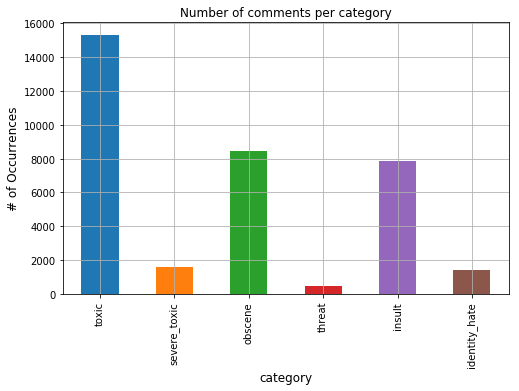

In [4]:
df_stats.plot(x='category', y='number_of_comments', kind='bar', legend=False, grid=True, figsize=(8, 5))
plt.title("Number of comments per category")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('category', fontsize=12)

### Multi-Label

How many comments have multiple labels?

Text(0.5,0,'# of categories')

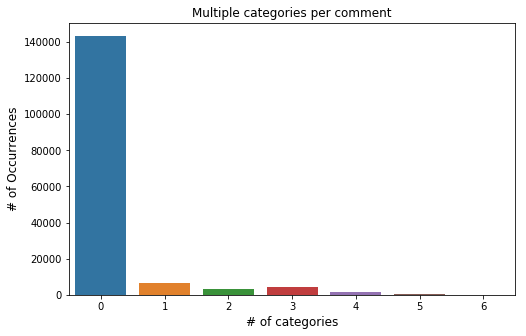

In [5]:
rowsums = df.iloc[:,2:].sum(axis=1)
x=rowsums.value_counts()

#plot
plt.figure(figsize=(8,5))
ax = sns.barplot(x.index, x.values)
plt.title("Multiple categories per comment")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('# of categories', fontsize=12)

Vast majority of the comment texts are not labeled.

The distribution of the number of words in comment texts.

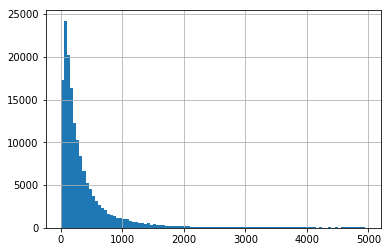

In [6]:
lens = df.comment_text.str.len()
lens.hist(bins = np.arange(0,5000,50))

Most of the comment text length are within 500 characters, with some outliers up to 5,000 characters long.

In [7]:
print('Percentage of comments that are not labelled:')
print(len(df[(df['toxic']==0) & (df['severe_toxic']==0) & (df['obscene']==0) & (df['threat']== 0) & (df['insult']==0) & (df['identity_hate']==0)]) / len(df))

Percentage of comments that are not labelled:
0


There is no missing comment in comment text column.

In [8]:
print('Number of missing comments in comment text:')
df['comment_text'].isnull().sum()

Number of missing comments in comment text:


0

Have a peek the first comment, the text needs clean.

In [9]:
df['comment_text'][0]

u"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

In [10]:
categories = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

### Create a function to clean the text

In [11]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

### Clean up comment_text column 

In [12]:
df['comment_text'] = df['comment_text'].map(lambda com : clean_text(com))

Much better!

In [13]:
df['comment_text'][0]

u'explanation why the edits made under my username hardcore metallica fan were reverted they were not vandalisms just closure on some gas after i voted at new york dolls fac and please do not remove the template from the talk page since i am retired now 89 205 38 27'

### Split to train and test sets

In [14]:
train, test = train_test_split(df, random_state=42, test_size=0.33, shuffle=True)

In [15]:
X_train = train.comment_text
X_test = test.comment_text
print(X_train.shape)
print(X_test.shape)

(106912,)
(52659,)


In [40]:
cheche_test = test[test['id'].isin(['e3b8bc8940f2a818','bf20893fb08e02ce','2b4077833a3730bf','a83932247fc191ff','4a25b2ea6cf8f636','1429a2c930688317','9e1ae3198f36411c','b825a93b71af1972','3fa752bec4e7f1d8'])]
print cheche_test
X_cheche_test = cheche_test.comment_text
#e3b8bc8940f2a818,bf20893fb08e02ce,2b4077833a3730bf,a83932247fc191ff,4a25b2ea6cf8f636,1429a2c930688317,9e1ae3198f36411c,b825a93b71af1972,3fa752bec4e7f1d8

                      id                                       comment_text  \
71398   bf20893fb08e02ce  and you are a motherfucking asshole suck your ...   
16423   2b4077833a3730bf  please do not add defamatory content to wikipe...   
138234  e3b8bc8940f2a818  oaks and homophobia i provided a full citation...   
62883   a83932247fc191ff                 listen up go fuck yourself asswipe   
28027   4a25b2ea6cf8f636  you are a pompous juvenile self aggrandizing f...   
144894  1429a2c930688317                          you fucking piece of shit   
125281  9e1ae3198f36411c  fred shut up you sad old twat no one is intere...   
155051  b825a93b71af1972  why are you still harassing me do you love bos...   
24088   3fa752bec4e7f1d8      hello go fuck yourself kid adults are talking   

        toxic  severe_toxic  obscene  threat  insult  identity_hate  
71398       1             1        1       0       1              0  
16423       1             0        1       0       1              0  

### Pipeline

scikit-learn provides a Pipeline utility to help automate machine learning workflows. Pipelines are very common in Machine Learning systems, since there is a lot of data to manipulate and many data transformations to apply. So we will utilize pipeline to train every classifier.

### OneVsRest multilabel strategy

The Multi-label algorithm accepts a binary mask over multiple labels. The result for each prediction will be an array of 0s and 1s marking which class labels apply to each row input sample.

### Naive Bayes

OneVsRest strategy can be used for multilabel learning, where a classifier is used to predict multiple labels for instance. Naive Bayes supports multi-class, but we are in a multi-label scenario, therefore, we wrapp Naive Bayes in the OneVsRestClassifier.

In [16]:
# Define a pipeline combining a text feature extractor with multi lable classifier
NB_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(MultinomialNB(
                    fit_prior=True, class_prior=None))),
            ])

In [45]:
for category in categories:
    print('... Processing {}'.format(category))
    # train the model using X_dtm & y
    print "======"
    print X_train[:2]
    print train[category][:2]
    NB_pipeline.fit(X_train, train[category])
    # compute the testing accuracy
    prediction = NB_pipeline.predict(X_test)
    print "**",NB_pipeline.predict(X_cheche_test)
    print "***",NB_pipeline.predict_proba(X_cheche_test)
    print('Test accuracy is {}'.format(accuracy_score(test[category], prediction)))

... Processing toxic
29614     sockpuppetry case you have been accused of soc...
109036    i have read the archives and various national ...
Name: comment_text, dtype: object
29614     0
109036    0
Name: toxic, dtype: int64
** [1 0 0 1 1 1 0 0 0]
*** [[0.00523156 0.99476844]
 [0.99211265 0.00788735]
 [0.90972248 0.09027752]
 [0.16627208 0.83372792]
 [0.45833499 0.54166501]
 [0.04603246 0.95396754]
 [0.81773904 0.18226096]
 [0.99633648 0.00366352]
 [0.83502514 0.16497486]]
Test accuracy is 0.919576900435
... Processing severe_toxic
29614     sockpuppetry case you have been accused of soc...
109036    i have read the archives and various national ...
Name: comment_text, dtype: object
29614     0
109036    0
Name: severe_toxic, dtype: int64
** [0 0 0 0 0 0 0 0 0]
*** [[9.73865064e-01 2.61349357e-02]
 [9.99999936e-01 6.35236122e-08]
 [9.99151568e-01 8.48431504e-04]
 [9.96522533e-01 3.47746675e-03]
 [9.95822202e-01 4.17779824e-03]
 [9.89936429e-01 1.00635714e-02]
 [9.99994404e-01 5.5958511

In [48]:
NB_pipeline.classes_

array([0, 1])

In [18]:
X_test[0]

u'explanation why the edits made under my username hardcore metallica fan were reverted they were not vandalisms just closure on some gas after i voted at new york dolls fac and please do not remove the template from the talk page since i am retired now 89 205 38 27'

In [44]:
for category in categories:
    print('... Processing {}'.format(category))
    print NB_pipeline.predict_proba(['COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK'])
    print NB_pipeline.predict(['COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK'])

... Processing toxic
[[9.99850254e-01 1.49745717e-04]]
[0]
... Processing severe_toxic
[[9.99850254e-01 1.49745717e-04]]
[0]
... Processing obscene
[[9.99850254e-01 1.49745717e-04]]
[0]
... Processing threat
[[9.99850254e-01 1.49745717e-04]]
[0]
... Processing insult
[[9.99850254e-01 1.49745717e-04]]
[0]
... Processing identity_hate
[[9.99850254e-01 1.49745717e-04]]
[0]


In [20]:
prediction[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

### LinearSVC

In [41]:
SVC_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(LinearSVC(), n_jobs=1)),
            ])

In [42]:
for category in categories:
    print('... Processing {}'.format(category))
    # train the model using X_dtm & y
    SVC_pipeline.fit(X_train, train[category])
    # compute the testing accuracy
    prediction = SVC_pipeline.predict(X_test)
    print "**",NB_pipeline.predict(X_cheche_test)
    print "***",NB_pipeline.predict_proba(X_cheche_test)
    print('Test accuracy is {}'.format(accuracy_score(test[category], prediction)))

... Processing toxic
** [0 0 0 0 0 0 0 0 0]
*** [[9.98413847e-01 1.58615279e-03]
 [9.99999952e-01 4.76239685e-08]
 [9.99385128e-01 6.14872290e-04]
 [9.98466239e-01 1.53376133e-03]
 [9.97380803e-01 2.61919749e-03]
 [9.97714879e-01 2.28512068e-03]
 [9.99995477e-01 4.52259756e-06]
 [1.00000000e+00 8.91833939e-11]
 [9.99906475e-01 9.35250136e-05]]
Test accuracy is 0.959816935377
... Processing severe_toxic
** [0 0 0 0 0 0 0 0 0]
*** [[9.98413847e-01 1.58615279e-03]
 [9.99999952e-01 4.76239685e-08]
 [9.99385128e-01 6.14872290e-04]
 [9.98466239e-01 1.53376133e-03]
 [9.97380803e-01 2.61919749e-03]
 [9.97714879e-01 2.28512068e-03]
 [9.99995477e-01 4.52259756e-06]
 [1.00000000e+00 8.91833939e-11]
 [9.99906475e-01 9.35250136e-05]]
Test accuracy is 0.990656867772
... Processing obscene
** [0 0 0 0 0 0 0 0 0]
*** [[9.98413847e-01 1.58615279e-03]
 [9.99999952e-01 4.76239685e-08]
 [9.99385128e-01 6.14872290e-04]
 [9.98466239e-01 1.53376133e-03]
 [9.97380803e-01 2.61919749e-03]
 [9.97714879e-01 2.285

### Logistic Regression

In [43]:
LogReg_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=1)),
            ])
for category in categories:
    print('... Processing {}'.format(category))
    # train the model using X_dtm & y
    LogReg_pipeline.fit(X_train, train[category])
    # compute the testing accuracy
    prediction = LogReg_pipeline.predict(X_test)
    print "**",NB_pipeline.predict(X_cheche_test)
    print "***",NB_pipeline.predict_proba(X_cheche_test)
    print('Test accuracy is {}'.format(accuracy_score(test[category], prediction)))

... Processing toxic
** [0 0 0 0 0 0 0 0 0]
*** [[9.98413847e-01 1.58615279e-03]
 [9.99999952e-01 4.76239685e-08]
 [9.99385128e-01 6.14872290e-04]
 [9.98466239e-01 1.53376133e-03]
 [9.97380803e-01 2.61919749e-03]
 [9.97714879e-01 2.28512068e-03]
 [9.99995477e-01 4.52259756e-06]
 [1.00000000e+00 8.91833939e-11]
 [9.99906475e-01 9.35250136e-05]]
Test accuracy is 0.954917487989
... Processing severe_toxic
** [0 0 0 0 0 0 0 0 0]
*** [[9.98413847e-01 1.58615279e-03]
 [9.99999952e-01 4.76239685e-08]
 [9.99385128e-01 6.14872290e-04]
 [9.98466239e-01 1.53376133e-03]
 [9.97380803e-01 2.61919749e-03]
 [9.97714879e-01 2.28512068e-03]
 [9.99995477e-01 4.52259756e-06]
 [1.00000000e+00 8.91833939e-11]
 [9.99906475e-01 9.35250136e-05]]
Test accuracy is 0.991055660001
... Processing obscene
** [0 0 0 0 0 0 0 0 0]
*** [[9.98413847e-01 1.58615279e-03]
 [9.99999952e-01 4.76239685e-08]
 [9.99385128e-01 6.14872290e-04]
 [9.98466239e-01 1.53376133e-03]
 [9.97380803e-01 2.61919749e-03]
 [9.97714879e-01 2.285